# Telco Customer Churn

Problem Statement : Predict the customer churn in the given dataset with the given input variavbles. <br>
Dataset Name : Teleco_Cust_Attr.csv <br>
Rows : 7043 <br>
Cols : 21 <br>

0. Libraries
1. Data Preparation
2. Missing Value Treatment

## 0. Libraries

In [28]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

# Data Transformation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#Data Split
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

#Grid Search
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

#Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

pd.set_option("display.max_columns",1000)

## 1. Data Preparation

This section considers : 

- Reading input dataset
- Data Cleaning
    - Trim Columns
    - Drop Duplicates
    - Datatype Conversion 

### 1.1 Read Input File

In [2]:
master_dataset = pd.read_csv("Datasets/Teleco_Cust_Attr.csv",header=0)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
num_rows = master_dataset.shape[0]
num_cols = master_dataset.shape[1]
print("Rows ",num_rows)
print("Cols ",num_cols)

Rows  7043
Cols  21


In the given dataset, Churn is the target variable and the dataset has 20 input variables with 7043 records. 

### 1.2 Data Cleaning

<b>1.2.1 Trim columns </b><br>
The function fn_trim_cols takes a dataframe as an input and returns a dataframe after stripping all leading and trailing spaces. 

In [4]:
def fn_trim_cols(df):
    clean_df = df.apply(lambda x: x.str.strip().replace('',np.nan) 
                        if x.dtype=="object"
                        else x)
    return clean_df

master_dataset = fn_trim_cols(master_dataset)

<b> 1.2.2 Drop Duplicates </b><br>
The function fn_del_dup_rows takes a dataframe as in input and checks for any duplicate records in the dataframe. If found, the duplicate rceords are dropped by preserving only one of the records. 
Next, the if any empty rows are found, the entire rows are dropped from the dataframe. The function returns two dataframes - the original dataframe and cleaned dataframe after removing duplicates and empty records.

In [5]:
def fn_del_dup_rows(df):
    duplicated_df = df.copy()
    tot_rows = duplicated_df.shape[0]
    
    # Dropping duplicate records
    df.drop_duplicates(inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Duplicates found. Total duplicates",tot_rows-distinct_rows)
    else:
        print("No duplicates found.")
    
    #Dropping empty records
    tot_rows = df.shape[0]
    df.dropna(axis=0, how='all',inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Empty records found. Total empty records",tot_rows-distinct_rows)
    else:
        print("No empty records found.")
              
    return duplicated_df,df

duplicated_df,master_dataset = fn_del_dup_rows(master_dataset)

No duplicates found.
No empty records found.


<b> 1.2.3 Datatype Conversion </b><br>
Looks like pandas has considered almost all variables as float and 2 variables as objects. Let's assign the actual datatypes to each of the variables. 

The function get_uniq_vals takes a dataframe as an input and returns a Series of unique values in each column. This helps in identifying the categorical variables in the dataset.

The function fn_set_dtypes takes 5 parameters as inputs - the dataframe, a list of all categorical variable names, a list of integers and a list of floats and a list of objects. 

The function returns a dataframe by assigning the appropriate datatype to each variable.

In [6]:
def get_uniq_vals(df):
    uniq_vals=pd.Series()
    for col in df.columns:
        uniq_vals[col]=df[col].unique().shape[0]
    return uniq_vals
        
get_uniq_vals(master_dataset)

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [7]:
master_dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
def fn_set_dtypes(df,categories_,ints_,floats_,objects_):
    for category_ in categories_:
        df[category_] = df[category_].astype("category")
        
    for int_ in ints_:
        df[int_] = df[int_].astype("int64")
        
    for float_ in floats_:
        df[float_] = df[float_].astype("float64")
        
    for object_ in objects_:
        df[object_] = df[object_].astype("object")
    return df


categories_=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines',
             'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod','Churn']
ints_=['tenure']
floats_=['MonthlyCharges','TotalCharges']
objects_=['customerID']
master_dataset = fn_set_dtypes(master_dataset,categories_,ints_,floats_,objects_)
master_dataset.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

## 2. Missing Value Treatment

Let's check if any variable has missing values in the dataset and use a correct method to impute.

The function fn_get_missing_vals takes a dataframe and returns a dataframe which contains the list of all variables and number of missing values in each variable along with percentages. 

In [9]:
def fn_get_missing_vals(df,cols_):
    df=df[cols_]
    n_rows = df.shape[0]
    miss_val_cnts = df.isna().sum()
    miss_vals = pd.DataFrame(miss_val_cnts[miss_val_cnts>0],columns=['Missing Val Count'])
    if miss_vals.shape[0]==0:
        return "No Missing Values Found"
    miss_vals['Percentage'] = miss_vals['Missing Val Count']*100/n_rows
    return miss_vals

fn_get_missing_vals(master_dataset,categories_+ints_+floats_+objects_)

,Missing Val Count,Percentage
TotalCharges,11,0.156183


### Missing Values in TotalCharges

<b> Method 1 : Comparing MonthlyCharges, tenure and TotalCharges variables. </b>

In [10]:
s = master_dataset[["MonthlyCharges","tenure","TotalCharges"]].copy()
s["TotalCharges_"] = s["MonthlyCharges"]*s["tenure"]
s["TotalCharges_diff"] = s["TotalCharges_"]-s["TotalCharges"]
s.head(10)

,MonthlyCharges,tenure,TotalCharges,TotalCharges_,TotalCharges_diff
0,29.85,1,29.85,29.85,0.00
1,56.95,34,1889.50,1936.30,46.80
2,53.85,2,108.15,107.70,-0.45
3,42.30,45,1840.75,1903.50,62.75
4,70.70,2,151.65,141.40,-10.25
5,99.65,8,820.50,797.20,-23.30
6,89.10,22,1949.40,1960.20,10.80
7,29.75,10,301.90,297.50,-4.40
8,104.80,28,3046.05,2934.40,-111.65
9,56.15,62,3487.95,3481.30,-6.65


In [11]:
s.describe()

,MonthlyCharges,tenure,TotalCharges,TotalCharges_,TotalCharges_diff
count,7043.000000,7043.000000,7032.000000,7043.000000,7032.000000
mean,64.761692,32.371149,2283.300441,2279.581350,-0.153193
std,30.090047,24.559481,2266.771362,2264.729447,67.255326
min,18.250000,0.000000,18.800000,0.000000,-373.250000
25%,35.500000,9.000000,401.450000,394.000000,-28.700000
50%,70.350000,29.000000,1397.475000,1393.600000,0.000000
75%,89.850000,55.000000,3794.737500,3786.100000,28.650000
max,118.750000,72.000000,8684.800000,8550.000000,370.850000


In [12]:
np.sqrt(np.sum(np.square(s["TotalCharges_diff"])))

5639.444924148121

Upon comparing the above values, looks like MonthlyCharges X tenure value is closer to TotalCharges. 
<br><i>Replacing the missing values with MonthlyCharges*tenure</i>

In [13]:
null_index=master_dataset.isna()["TotalCharges"]
master_dataset["TotalCharges"].fillna(master_dataset["MonthlyCharges"]*master_dataset["tenure"],inplace=True)

<b> Method 2 : Predicting TotalCharges column </b>

In [14]:
fn_get_missing_vals(master_dataset,categories_+ints_+floats_+objects_)

'No Missing Values Found'

Looks like we've handled all missing values :)

## 3. Class Imbalance

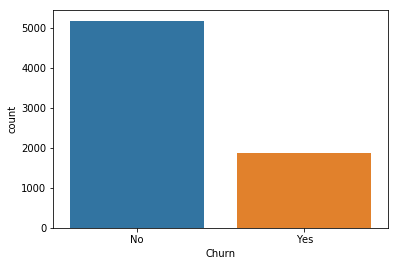

In [15]:
sn.countplot("Churn", data=master_dataset)

In [16]:
def fn_get_class_dist(values):
    all_cat_dist={}
    cat_cnts = values.value_counts()
    cat_per = cat_cnts*100/sum(cat_cnts)
    for cat_ in cat_cnts.index:
        cat_dist={}
        cat_dist["Count"]=cat_cnts[cat_]
        cat_dist["Percentage"]=cat_per[cat_]
        all_cat_dist[cat_]=cat_dist
    return all_cat_dist

In [17]:
fn_get_class_dist(master_dataset["Churn"])

{'No': {'Count': 5174, 'Percentage': 73.46301292063042},
 'Yes': {'Count': 1869, 'Percentage': 26.536987079369588}}

No class has 73% data where as yes class has 26% data. Theere is class imbalance in this dataset.

## 4. Exploratory Data Analysis

## 5. Outlier Treatment

## 6. Scaling and Encoding 

- Scaling -- Scaling is used to standardize the range of continous independent variables
- Encoding -- Encoding transforms categorical features to a format that works better with classification algorithms.
    - Label Encoding - Encode labels with value between 0 and n_classes-1. 
    - One Hot Encoding - Encode categorical integer features using a one-hot aka one-of-K scheme.

### 6.1 Scaling Continous variables

- Scaling -- Scaling is used to standardize the range of continous independent variables
    - Min Max Scaling - The function fn_minMax_scale takes a dafarame as an input and the list of columns to be scaled and returns a dataframe with the new scaled columns. This function uses MinMaxScaler() to scale the data. In MinMax Scaling all the values lie between 0 an 1. 
    - Standard Scalar - The function fn_SS_scale takes a dafarame as an input and the list of columns to be scaled and returns a dataframe with the new scaled columns. This function uses StandardScaler() to scale the data.  Mean of the varible becomes 0 with a Standard deviation of 1. 

<b> Min Max Scaling </b>

In [18]:
def fn_minMax_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = MinMaxScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"minMax_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("minMax_"+variable_)
    return df,scaled_num_features,scale_obj

<b> Standard Scaler </b>

In [19]:
def fn_SS_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = StandardScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"SS_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("SS_"+variable_)
    return df,scaled_num_features,scale_obj

In [20]:
master_dataset,scaled_ss_nums_,SS_scale_obj = fn_SS_scale(master_dataset,ints_+floats_)

In [21]:
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SS_tenure,SS_MonthlyCharges,SS_TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,-1.277445,-1.160323,-0.992611
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.066327,-0.259629,-0.172165
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,-1.236724,-0.362660,-0.958066
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.514251,-0.746535,-0.193672
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,-1.236724,0.197365,-0.938874


### 6.2  Encoding Categorical Variables
- Encoding -- Encoding transforms categorical features to a format that works better with classification algorithms.
    - Label Encoding - Encode labels with value between 0 and n_classes-1.  The function fn_label_Enc takes a dataframe as an input and a list of columns to be label encoded and returns the data frame by appeniding the new label encoded columns. 
    - One Hot Encoding - Encode categorical integer features using a one-hot aka one-of-K scheme.

<b> Label Encoding </b>

In [22]:
def fn_label_Enc(df,cat_cols):
    label_enc_obj = {}
    labelEnc_features=[]
    for variable_ in cat_cols:
        le = LabelEncoder()
        data_=df[variable_]
        le.fit(data_)
        df.loc[:,"LE_"+variable_]=le.transform(data_)
        label_enc_obj[variable_]=le
        labelEnc_features.append("LE_"+variable_)
    return df,labelEnc_features,label_enc_obj  

In [23]:
master_dataset,labEnc_categories_,labEnc_obj = fn_label_Enc(master_dataset,categories_)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SS_tenure,SS_MonthlyCharges,SS_TotalCharges,LE_gender,LE_SeniorCitizen,LE_Partner,LE_Dependents,LE_PhoneService,LE_MultipleLines,LE_InternetService,LE_OnlineSecurity,LE_OnlineBackup,LE_DeviceProtection,LE_TechSupport,LE_StreamingTV,LE_StreamingMovies,LE_Contract,LE_PaperlessBilling,LE_PaymentMethod,LE_Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,-1.277445,-1.160323,-0.992611,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.066327,-0.259629,-0.172165,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,-1.236724,-0.362660,-0.958066,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.514251,-0.746535,-0.193672,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,-1.236724,0.197365,-0.938874,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


## 6. Train Test Split

The function fn_train_test_split takes a dataframe as an input and a list of target variables and returns 4 dataframes - X Train , X Test, Y Train and Y Test. 

In [26]:
def fn_train_test_split(input_df,target):
    X = input_df.drop(target,axis=1)
    y = input_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 120)
    print(" X Shape : ",X.shape)
    print(" X Train Shape : ",X_train.shape)
    print(" X Test Shape : ",X_test.shape)
    print(" Y Shape : ",y.shape)
    print(" Y Train Shape : ",y_train.shape)
    print(" Y Test Shape : ",y_test.shape)
    return X,y,X_train,X_test,y_train,y_test

X,Y,X_train,X_test,y_train,y_test = fn_train_test_split(master_dataset,["Churn","LE_Churn"])

 X Shape :  (7043, 39)
 X Train Shape :  (5282, 39)
 X Test Shape :  (1761, 39)
 Y Shape :  (7043, 2)
 Y Train Shape :  (5282, 2)
 Y Test Shape :  (1761, 2)


## 7. K Nearest Neighbours

### 7.1 K-NN Classifer

#### 7.1.1 Finalise Variables

In [229]:
input_var = labEnc_categories_+ints_+floats_
input_var.remove("LE_Churn")
target_ = "LE_Churn"

In [230]:
knn_model = KNeighborsClassifier(n_neighbors=3,p=1)
knn_model.fit(X_train[input_var],y_train[target_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='uniform')

In [231]:
knn_predictions_train = knn_model.predict(X_train[input_var])
knn_predictions_test = knn_model.predict(X_test[input_var])

In [232]:
def fn_get_classification_report(actuals,preds):
    classificaiton_report = classification_report(actuals,preds)
    conf_mat = confusion_matrix(actuals,preds)
    return classificaiton_report,conf_mat

In [235]:
def fn_get_metrics(confusion_matrix):
    tru_pos = confusion_matrix[1][1]
    tru_neg = confusion_matrix[0][0]
    fals_pos = confusion_matrix[0][1]
    fals_neg = confusion_matrix[1][0]
    
    if tru_pos+tru_neg+fals_pos+fals_neg == 0:
        accuracy = -1
    else:
        accuracy = (tru_pos+tru_neg)/(tru_pos+tru_neg+fals_pos+fals_neg)
        
    if tru_pos+fals_pos == 0:
        precision = -1
    else:
        precision = tru_pos /(tru_pos+fals_pos)
        
    if tru_pos+fals_neg == 0:
        recall = -1
    else:
        recall = tru_pos/(tru_pos+fals_neg)
        
    if precision+recall == 0:
        f1_score = -1
    else:
        f1_score = 2*precision*recall/(precision+recall)
        
    accuracy = round(accuracy,3)
    precision = round(precision,3)
    recall = round(recall,3)
    f1_score = round(f1_score,3)
    
    metrics = {"0 True Positive":tru_pos,
               "1 True Negative":tru_neg,
               "2 False Positive":fals_pos,
               "3 False Negative":fals_neg,
               "4 Accuracy":accuracy,
               "5 Precision":precision,
               "6 Recall":recall,
               "7 F1 Score":f1_score
              }
    
    return metrics

In [236]:
knn_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
    y_train[target_],
    knn_predictions_train)

In [237]:
print(knn_classificaiton_report_train)

             precision    recall  f1-score   support

          0       0.89      0.92      0.91      3883
          1       0.76      0.69      0.72      1399

avg / total       0.86      0.86      0.86      5282



In [238]:
conufsion_matrix_train

array([[3578,  305],
       [ 440,  959]])

In [239]:
fn_get_metrics(conufsion_matrix_train)

{'0 True Positive': 959,
 '1 True Negative': 3578,
 '2 False Positive': 305,
 '3 False Negative': 440,
 '4 Accuracy': 0.859,
 '5 Precision': 0.759,
 '6 Recall': 0.685,
 '7 F1 Score': 0.72}

In [240]:
knn_classificaiton_report_test,conufsion_matrix_test=fn_get_classification_report(
    y_test[target_],
    knn_predictions_test)

In [241]:
print(knn_classificaiton_report_test)

             precision    recall  f1-score   support

          0       0.82      0.86      0.84      1291
          1       0.55      0.48      0.51       470

avg / total       0.75      0.76      0.75      1761



In [217]:
conufsion_matrix_test

array([[1196,   95],
       [ 288,  182]])

In [218]:
fn_get_metrics(conufsion_matrix_test)

{'0 True Positive': 182,
 '1 True Negative': 1196,
 '2 False Positive': 95,
 '3 False Negative': 288,
 '4 Accuracy': 0.783,
 '5 Precision': 0.657,
 '6 Recall': 0.387,
 '7 F1 Score': 0.487}

In [227]:
precision=[]
for i in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=i,p=1)
    knn_model.fit(X_train[input_var],y_train[target_])
    knn_predictions_train = knn_model.predict(X_train[input_var])
    knn_classificaiton_report_train,conufsion_matrix_train=fn_get_classification_report(
        y_train[target_],knn_predictions_train)
    precision.append(fn_get_metrics(conufsion_matrix_train)['5 Precision'])

In [228]:
precision

[0.998,
 1.0,
 0.759,
 0.833,
 0.732,
 0.778,
 0.705,
 0.753,
 0.704,
 0.736,
 0.708,
 0.734,
 0.698,
 0.722,
 0.691,
 0.717,
 0.688,
 0.713,
 0.694,
 0.721,
 0.691,
 0.704,
 0.702,
 0.711,
 0.701,
 0.718,
 0.703,
 0.72,
 0.703]